Code in this notebook is used for downloading and processing data (from the CDC and other sources) to prepare for analysis. The data from this step is placed in the `data/` folder.

In [ ]:
# COPY THIS
from google.colab import drive
import os

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/data102')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
!pip install sodapy
from sodapy import Socrata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1


In [ ]:
from scripts.state_agg import get_cdc_data, agg_county_weighted_mean

# Ozone Data

Downloads data from the CDC's [Daily Census Tract-Level Ozone Concentrations](https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-Ozone-Concentrations-2011/372p-dx3h) and aggregates county-level data to state-level using a weighted mean based on county's population. We do this for the first day of every month from January 2011 to December 2014, then take the mean over all of these to calculate the average ozone concentration for the 4 years.

The resulting DataFrame is saved as a csv file at `data/average_ozone_per_state.csv`

In [ ]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
dates = sum([["01"+m+str(yr) for m in months] for yr in np.arange(2011, 2015)], [])
ozone = get_cdc_data(dates, ozone=True)

100%|██████████| 48/48 [01:25<00:00,  1.78s/it]


In [ ]:
ozone_by_state = agg_county_weighted_mean(ozone)
ozone_by_state = ozone_by_state.set_index('abbrev')

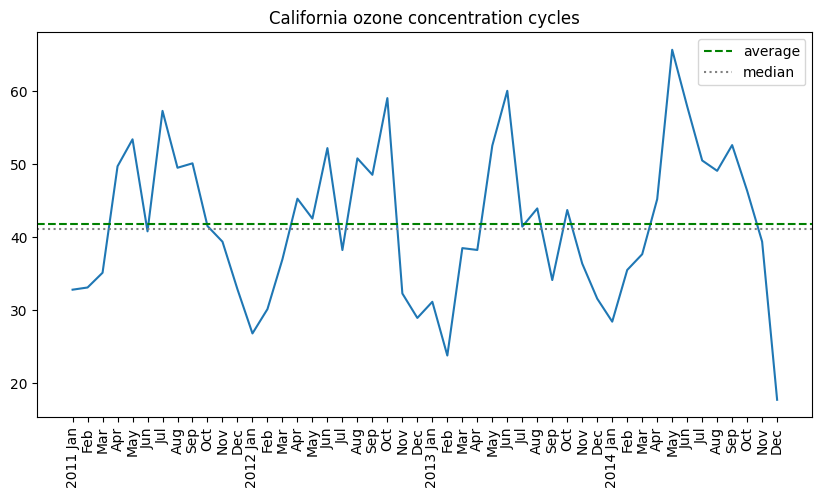

In [ ]:
plt.figure(figsize=(10, 5))

cali = ozone_by_state.loc['CA'].drop('state')
plt.plot(cali)

labels = [x.capitalize() for x in months]*4
for i in range(4): labels[i*12] = str(i+2011) + " " + labels[i*12]

plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
plt.title("California ozone concentration cycles")

plt.axhline(y=cali.mean(), c="g", linestyle='--', label="average")
plt.axhline(y=cali.median(), c="gray", linestyle=':', label="median")
plt.legend()

plt.show()

In [ ]:
ozone_by_state['average o3'] = ozone_by_state.drop(columns='state').mean(axis=1)
ozone_by_state['median o3'] = ozone_by_state.drop(columns=['state', 'average o3']).median(axis=1)
ozone_by_state.head()

,01JAN2011,01FEB2011,01MAR2011,01APR2011,01MAY2011,01JUN2011,01JUL2011,01AUG2011,01SEP2011,01OCT2011,...,01JUN2014,01JUL2014,01AUG2014,01SEP2014,01OCT2014,01NOV2014,01DEC2014,state,average o3,median o3
abbrev,,,,,,,,,,,,,,,,,,,,,
AL,32.800725,32.106784,40.581678,45.007609,50.313911,59.588814,67.606191,48.655905,47.278650,36.598643,...,34.342147,29.542927,46.146038,26.413159,41.874094,29.427147,29.276008,Alabama,38.952453,38.014230
AZ,36.787240,42.331850,45.744664,51.174422,55.747288,56.176224,61.125285,61.859581,66.579169,49.857348,...,48.489728,43.801846,59.045170,44.692913,53.841281,35.885434,26.847761,Arizona,47.218526,48.273779
AR,30.783635,34.040496,38.151609,40.824698,37.539124,47.634169,61.597302,58.904620,64.182481,39.705268,...,26.806301,34.721968,36.168714,27.887003,36.241424,35.774794,15.640119,Arkansas,39.328185,38.236533
CA,32.794612,33.094941,35.116976,49.714317,53.414567,40.796824,57.315606,49.513634,50.121815,41.520038,...,57.935336,50.513304,49.093269,52.622622,46.358157,39.380798,17.697704,California,41.850958,41.119701
CO,37.027643,34.749600,44.358696,47.905271,49.339591,49.050829,63.991913,60.120343,62.106623,51.556652,...,55.936008,53.015487,52.978324,55.645615,39.378438,29.734833,23.403740,Colorado,45.143085,46.524904


In [ ]:
ozone_by_state[['state', 'average o3', 'median o3']].to_csv("data/average_ozone_by_state.csv")

In [ ]:
fig = px.choropleth(
    title=r"Average ozone concentration (2011-2014)",
    locations=ozone_by_state.index,
    locationmode="USA-states",
    color=ozone_by_state['average o3'],
    scope="usa",
)
fig.layout.coloraxis.colorbar.title = "ppb"
fig.show()

# PM 2.5 Data

Downloads data from the CDC's [Daily Census Tract-Level PM2.5 Concentrations](https://data.cdc.gov/Environmental-Health-Toxicology/Daily-Census-Tract-Level-PM2-5-Concentrations-2011/fcqm-xrf4) and aggregates county-level data to state-level using a weighted mean based on county's population. We do this for the first day of every month from January 2011 to December 2014, then take the mean over all of these to calculate the average ozone concentration for the 4 years.

The resulting DataFrame is saved as a csv file at `data/average_pm_by_state.csv`

In [ ]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
dates = sum([["01"+m+str(yr) for m in months] for yr in np.arange(2011, 2015)], [])
pm25 = get_cdc_data(dates, ozone=False)

100%|██████████| 48/48 [01:26<00:00,  1.80s/it]


In [ ]:
pm25_by_state = agg_county_weighted_mean(pm25)
pm25_by_state = pm25_by_state.set_index('abbrev')

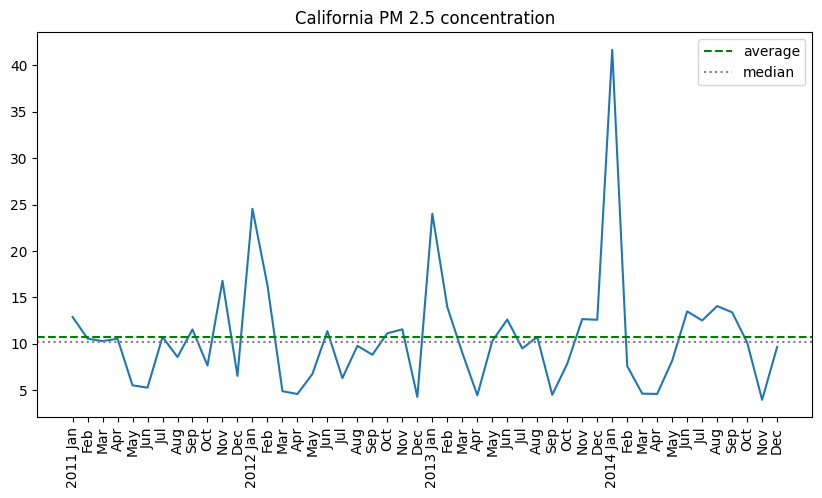

In [ ]:
plt.figure(figsize=(10, 5))

cali_pm25 = pm25_by_state.loc['CA'].drop('state')
plt.plot(cali_pm25)

labels = [x.capitalize() for x in months]*4
for i in range(4): labels[i*12] = str(i+2011) + " " + labels[i*12]

plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
plt.title("California PM 2.5 concentration")

plt.axhline(y=cali_pm25.mean(), c="g", linestyle='--', label="average")
plt.axhline(y=cali_pm25.median(), c="gray", linestyle=':', label="median")
plt.legend()

plt.show()

In [ ]:
pm25_by_state['average pm'] = pm25_by_state.drop(columns='state').mean(axis=1)
pm25_by_state['median pm'] = pm25_by_state.drop(columns=['state', 'average pm']).median(axis=1)
pm25_by_state.head()

,01JAN2011,01FEB2011,01MAR2011,01APR2011,01MAY2011,01JUN2011,01JUL2011,01AUG2011,01SEP2011,01OCT2011,...,01JUN2014,01JUL2014,01AUG2014,01SEP2014,01OCT2014,01NOV2014,01DEC2014,state,average pm,median pm
abbrev,,,,,,,,,,,,,,,,,,,,,
AL,4.869288,10.560592,9.702467,9.543263,10.184194,21.352466,15.752966,14.647785,16.769248,4.701570,...,7.708895,22.966910,13.612457,13.149661,14.263774,4.502698,8.920221,Alabama,11.355918,10.372393
AZ,8.443013,7.793776,6.703184,7.116633,6.125074,9.730045,9.017771,5.612779,11.104314,7.528527,...,4.999736,4.887055,5.986039,5.112879,6.712159,7.671613,9.214203,Arizona,8.491356,7.273586
AR,5.425044,9.720308,9.836417,8.146574,6.774549,12.278430,15.002441,14.401427,22.660664,6.212175,...,4.919836,23.433149,10.472068,9.923289,14.137776,4.590902,8.053610,Arkansas,10.340648,9.879853
CA,12.894529,10.561290,10.291104,10.544684,5.525246,5.274675,10.737480,8.579785,11.549225,7.663191,...,13.495823,12.510747,14.068341,13.393390,10.152339,3.967613,9.654263,California,10.697090,10.221722
CO,4.479827,4.805708,5.253930,4.064448,4.019563,9.525098,7.272776,5.805288,8.371750,5.827588,...,5.228194,11.874387,5.753956,6.652031,4.220164,11.480503,12.177480,Colorado,6.428844,5.868987


In [ ]:
pm25_by_state[['state', 'average pm', 'median pm']].to_csv("data/average_pm_by_state.csv")

In [ ]:
fig = px.choropleth(
    title=r"Average PM 2.5 concentration (2011-2014)",
    locations=pm25_by_state.index,
    locationmode="USA-states",
    color=pm25_by_state['average pm'],
    scope="usa",
)
fig.layout.coloraxis.colorbar.title = "μg/m^3"
fig.show()

## Notes

Since we are trying see the effects of ozone and PM 2.5 concentration on chronic diseases, we are worried more about extended air quality patterns, rather than specific years of data. It is much more likely that chronic diseases will stem from extended exposure to air pollutants, rather than a small time period. We take the average over all the data available (January 2011 to December 2014), which assumes that this period is at least relatively representative of the long-term patterns before 2011.